<a href="https://colab.research.google.com/github/merrykang/AI/blob/main/22_2_AI_project_UNet_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[0. Loading Required Libraries]**

In [ ]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [ ]:
# Common
import os 
import keras
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf

# Data
import tensorflow.image as tfi
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Add
from keras.layers import concatenate
from keras.layers import Multiply
from keras.layers import Input


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Add


# Metrics
from keras.metrics import MeanIoU

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# **[1. Reading The Data: covid image, mask]**

### - google drive mount & unzip

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip /content/gdrive/"MyDrive"/22_2_AI_project/archive.zip -d /content/gdrive/"MyDrive"/22_2_AI_project/UNet/

Archive:  /content/gdrive/MyDrive/22_2_AI_project/archive.zip
replace /content/gdrive/MyDrive/22_2_AI_project/UNet/COVID-19_Radiography_Dataset/COVID.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### - reading the data 

In [ ]:
def load_image(image, SIZE):
    image = tf.cast(tfi.resize(img_to_array(load_img(image)), (SIZE, SIZE)), tf.float32)/255.
    return image

def load_images(paths, SIZE, trim=None, channels=3):
  
    if trim is not None:
        paths = paths[:trim]
        images = np.zeros(shape=(len(paths), SIZE, SIZE, channels))

    if channels==3:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img
    elif channels==1:
        for i, path in enumerate(paths):
            img = load_image(path, SIZE)
            images[i] = img[:,:,:1]
    return images

def show_image(image, title=None, cmap=None, alpha=1.0):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None: plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap='jet', alpha=0.2):
    show_image(image)
    show_image(tf.squeeze(mask), cmap=cmap, alpha=alpha)

In [ ]:
root_path = '/content/gdrive/MyDrive/22_2_AI_project/UNet/COVID-19_Radiography_Dataset/COVID/'
image_path = root_path + 'images/'
mask_path = root_path + 'masks/'

In [ ]:
image_paths = sorted(glob(image_path + '*.png'))
mask_paths = []
for path in image_paths:
    mask_paths.append(path.replace('images','masks'))

### - check images

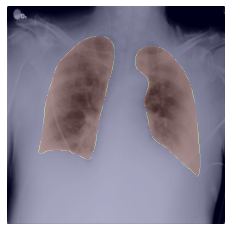

In [ ]:
show_mask(images[0], masks[0], alpha=0.2)

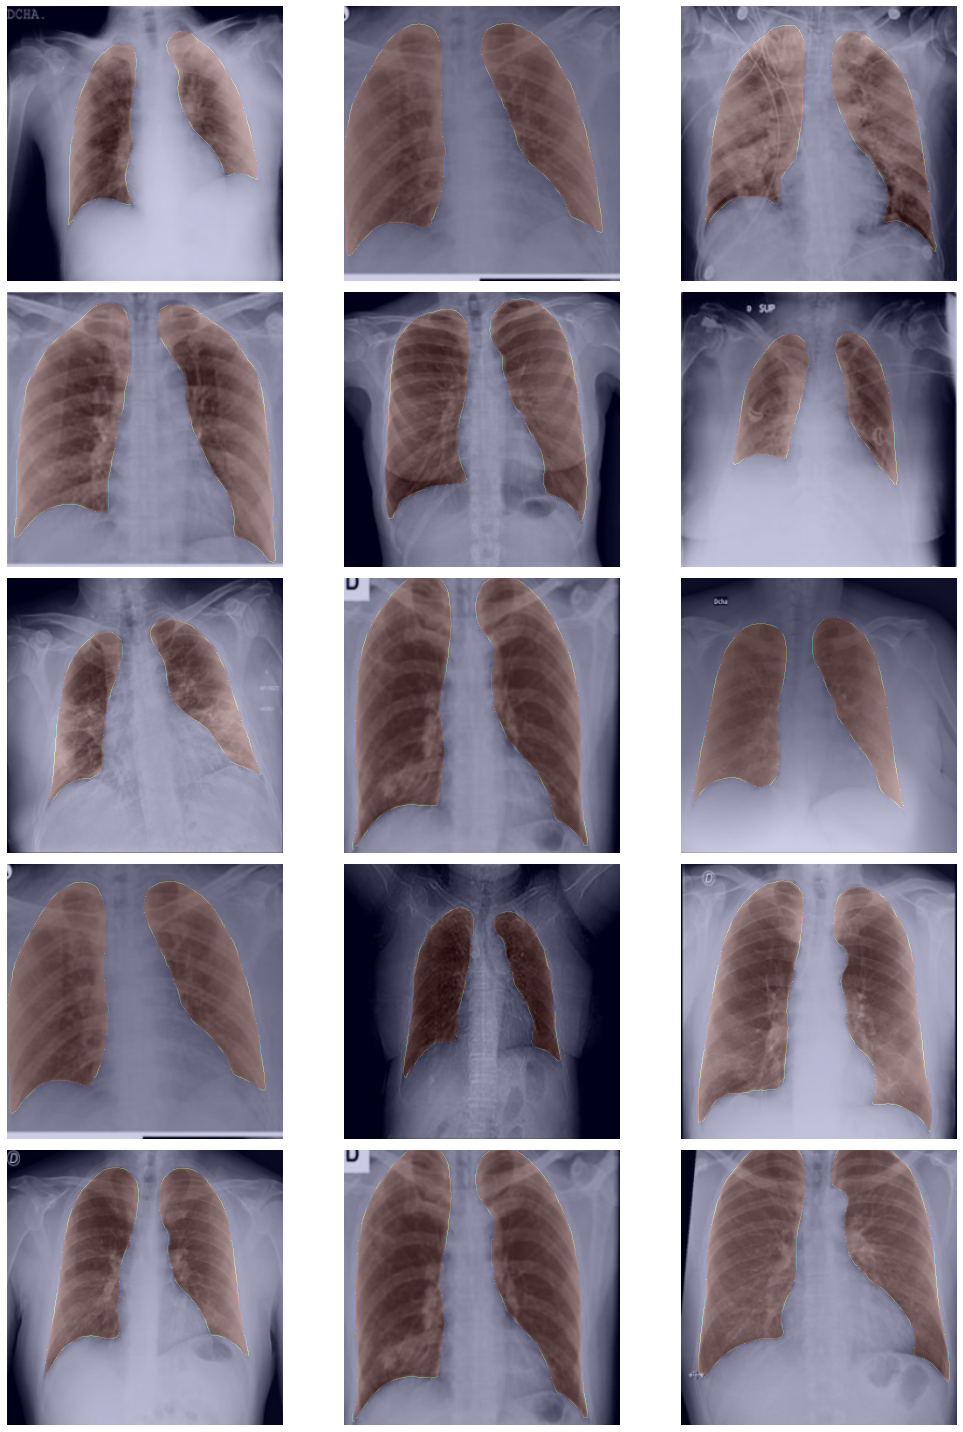

In [ ]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id])
plt.tight_layout()
plt.show()

### - splitting data

In [ ]:
SIZE = 256
images, masks = load_images(image_paths, SIZE, trim=2000), load_images(mask_paths, SIZE, trim=2000, channels=1)

In [ ]:
def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "rgb"):
    img_array = list()
    mask_array = list()

    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape)
        resized_image = resized_image/255.
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])
      # img_array.append(resized_image)
  
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])
        # mask_array.append(resized_image)

    return img_array, mask_array
img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (256,256), color_mode = "gray")

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size = 0.2, random_state= 42)

img_side_size = 256
images_train = np.array(images_train).reshape(len(images_train), img_side_size, img_side_size)
images_test = np.array(images_test).reshape(len(images_test), img_side_size, img_side_size)
masks_train = np.array(masks_train).reshape(len(masks_train), img_side_size, img_side_size)
mask_test = np.array(masks_test).reshape(len(masks_test), img_side_size, img_side_size)

ValueError: ignored

In [ ]:
len(images)

2000

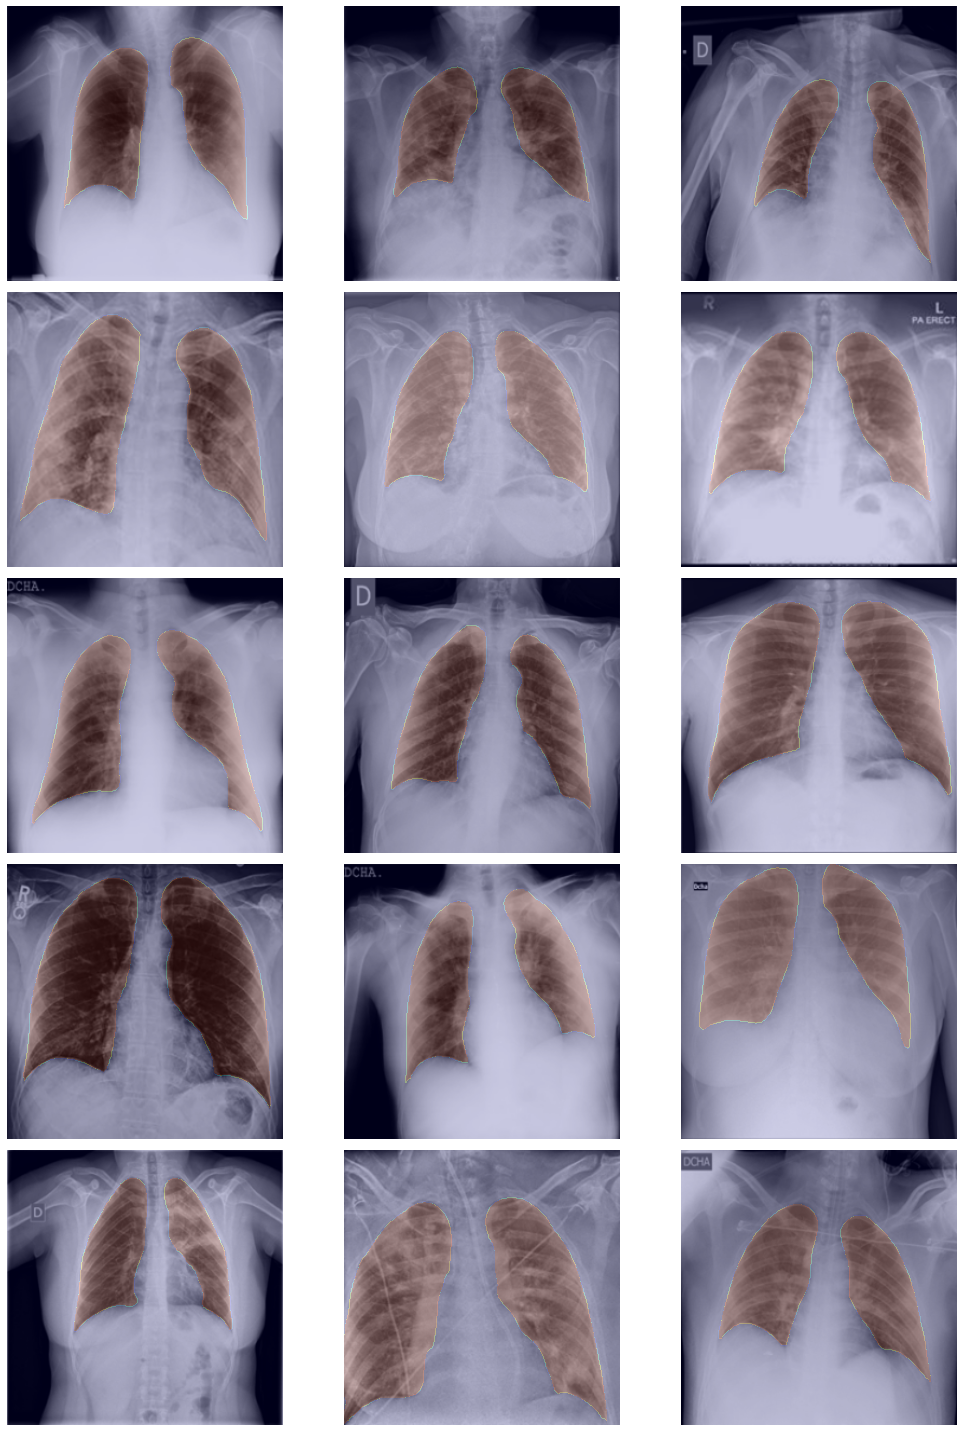

In [ ]:
plt.figure(figsize=(15,20))
for i in range(1,16):
    plt.subplot(5,3,i) #figure 형태에 subplot 추가
    id = np.random.randint(len(images))  #images, masks에서 랜덤으로 뽑기 
    show_mask(images[id], masks[id])
plt.tight_layout() #함수에 명시된 여백에 자동으로 파라미터 추가 
plt.show()

# **[2. Modeling]**

## **1) batch size**

In [ ]:
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

## **2) convolution block**

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    

    if dropout_prob > 0:         
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D()(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv


## **3) unsampling block**

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=1):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)

    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)

    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same', activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_height = 256
img_width = 256
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

## **4) compile the model**

In [ ]:
unet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',MeanIoU(2)])

## **5) save the checkpoint**

In [ ]:
checkpoint_filepath = "/content/gdrive/MyDrive/AI_class_2022_2/checkpoint/best_cnn.ckpt"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

## **6) train the model**

In [ ]:
history = unet.fit(
          images, masks,
          validation_split=0.1,
          epochs=10, # This is more than sufficient
          steps_per_epoch=SPE
)

Epoch 1/10
250/250 [==============================] - 22s 42ms/step - loss: 0.4336 - accuracy: 0.7868 - mean_io_u: 0.3761 - val_loss: 0.1869 - val_accuracy: 0.9347 - val_mean_io_u: 0.3875
Epoch 2/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1707 - accuracy: 0.9343 - mean_io_u: 0.3782 - val_loss: 0.1090 - val_accuracy: 0.9554 - val_mean_io_u: 0.3875
Epoch 3/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1155 - accuracy: 0.9550 - mean_io_u: 0.3843 - val_loss: 0.0826 - val_accuracy: 0.9669 - val_mean_io_u: 0.3877
Epoch 4/10
250/250 [==============================] - 9s 36ms/step - loss: 0.1001 - accuracy: 0.9613 - mean_io_u: 0.3863 - val_loss: 0.0576 - val_accuracy: 0.9778 - val_mean_io_u: 0.3927
Epoch 5/10
250/250 [==============================] - 9s 36ms/step - loss: 0.0822 - accuracy: 0.9681 - mean_io_u: 0.3997 - val_loss: 0.0472 - val_accuracy: 0.9814 - val_mean_io_u: 0.3973
Epoch 6/10
250/250 [==============================] - 9s 36ms/st

250/250 [==============================] - 1s 2ms/step - loss: 0.0460 - accuracy: 0.9818 - mean_io_u: 0.4684 - val_loss: 0.0311 - val_accuracy: 0.9876 - val_mean_io_u: 0.5628


# **[3. Evaluation]**

## **1) predicted image**

1/1 [==============================] - 0s 273ms/step


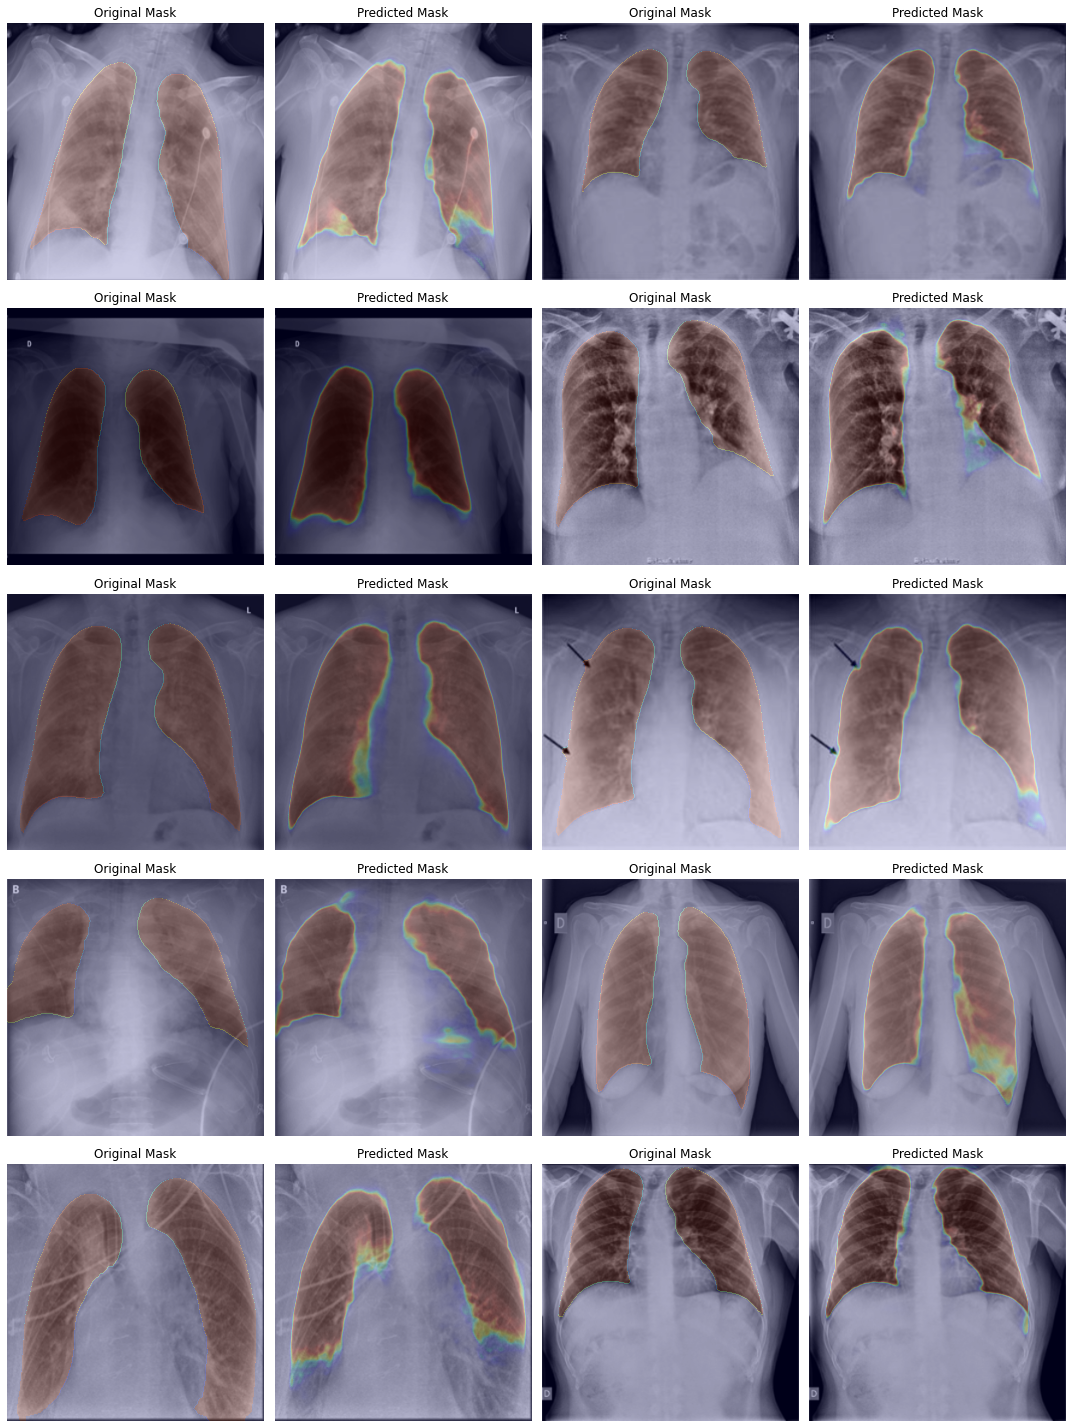

In [ ]:
plt.figure(figsize=(15,20))
n = 0
for i in range(1,21):
    plt.subplot(5,4,i)

    if n==0:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==1:
        pred_mask = unet.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n+=1
    elif n==2:
        id = np.random.randint(len(images))
        image, mask = images[id], masks[id]
        plt.title("Original Mask")
        show_mask(image, mask)
        n+=1
    elif n==3:
        pred_mask = unet.predict(image[np.newaxis,...])[0]
        plt.title("Predicted Mask")
        show_mask(image, pred_mask)
        n=0
plt.tight_layout()
plt.show()



## **2) accuracy, loss graph**

NameError: ignored

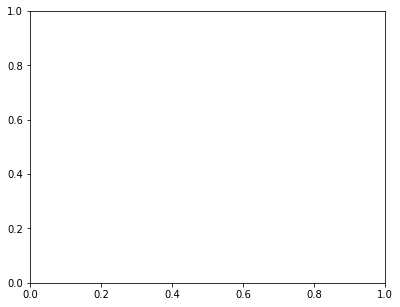

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# **[5. image만 사용- covid, normal]**

##**0) Downgrad package's versions**

In [ ]:
!pip uninstall keras  
!pip uninstall tensorflow

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.9.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.9.0
Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.9.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y

y
  Successfully uninstalled tensorflow-2.9.2


In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.2.0

In [ ]:
print(keras.__version__)
print(tensorflow.__version__)